# 1、项目背景

评估个人信用等级；

数据源中包含150000条用户数据，11个变量

# 2、数据导入

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression,LassoCV,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,accuracy_score,precision_score,recall_score,roc_auc_score
import warnings
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings('ignore')

In [8]:
import pandas as pd
df0=pd.read_csv('cs-training.csv')
df0

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [9]:
#将列名调整为中文
df0.rename(columns = {'SeriousDlqin2yrs':'未来两年可能违约', 'RevolvingUtilizationOfUnsecuredLines':'可用信贷额度比例', 'age':'年龄',
       'NumberOfTime30-59DaysPastDueNotWorse':'逾期30-59天的笔数', 'DebtRatio':'负债率', 'MonthlyIncome':'月收入',
       'NumberOfOpenCreditLinesAndLoans':'信贷数量', 'NumberOfTimes90DaysLate':'逾期90天+的笔数',
       'NumberRealEstateLoansOrLines':'固定资产贷款数', 'NumberOfTime60-89DaysPastDueNotWorse':'逾期60-89天的笔数',
       'NumberOfDependents':'家属数量'},inplace=True)
print(df0.info())
print(df0.head().T)
df0.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150000 non-null  int64  
 1   未来两年可能违约     150000 non-null  int64  
 2   可用信贷额度比例     150000 non-null  float64
 3   年龄           150000 non-null  int64  
 4   逾期30-59天的笔数  150000 non-null  int64  
 5   负债率          150000 non-null  float64
 6   月收入          120269 non-null  float64
 7   信贷数量         150000 non-null  int64  
 8   逾期90天+的笔数    150000 non-null  int64  
 9   固定资产贷款数      150000 non-null  int64  
 10  逾期60-89天的笔数  150000 non-null  int64  
 11  家属数量         146076 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB
None
                       0            1            2           3             4
Unnamed: 0      1.000000     2.000000     3.000000     4.00000      5.000000
未来两年可能违约        1.000000     0.000000     0.000000     0.00000      0.000000


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
未来两年可能违约,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
可用信贷额度比例,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
逾期30-59天的笔数,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
负债率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
信贷数量,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
逾期90天+的笔数,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
固定资产贷款数,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


月收入和家属数量存在缺失值

# 3、查看数据情况

In [10]:
#查看是否有缺失值
print(df0.未来两年可能违约.value_counts())
df0.isnull().sum()

0    139974
1     10026
Name: 未来两年可能违约, dtype: int64


Unnamed: 0         0
未来两年可能违约           0
可用信贷额度比例           0
年龄                 0
逾期30-59天的笔数        0
负债率                0
月收入            29731
信贷数量               0
逾期90天+的笔数          0
固定资产贷款数            0
逾期60-89天的笔数        0
家属数量            3924
dtype: int64

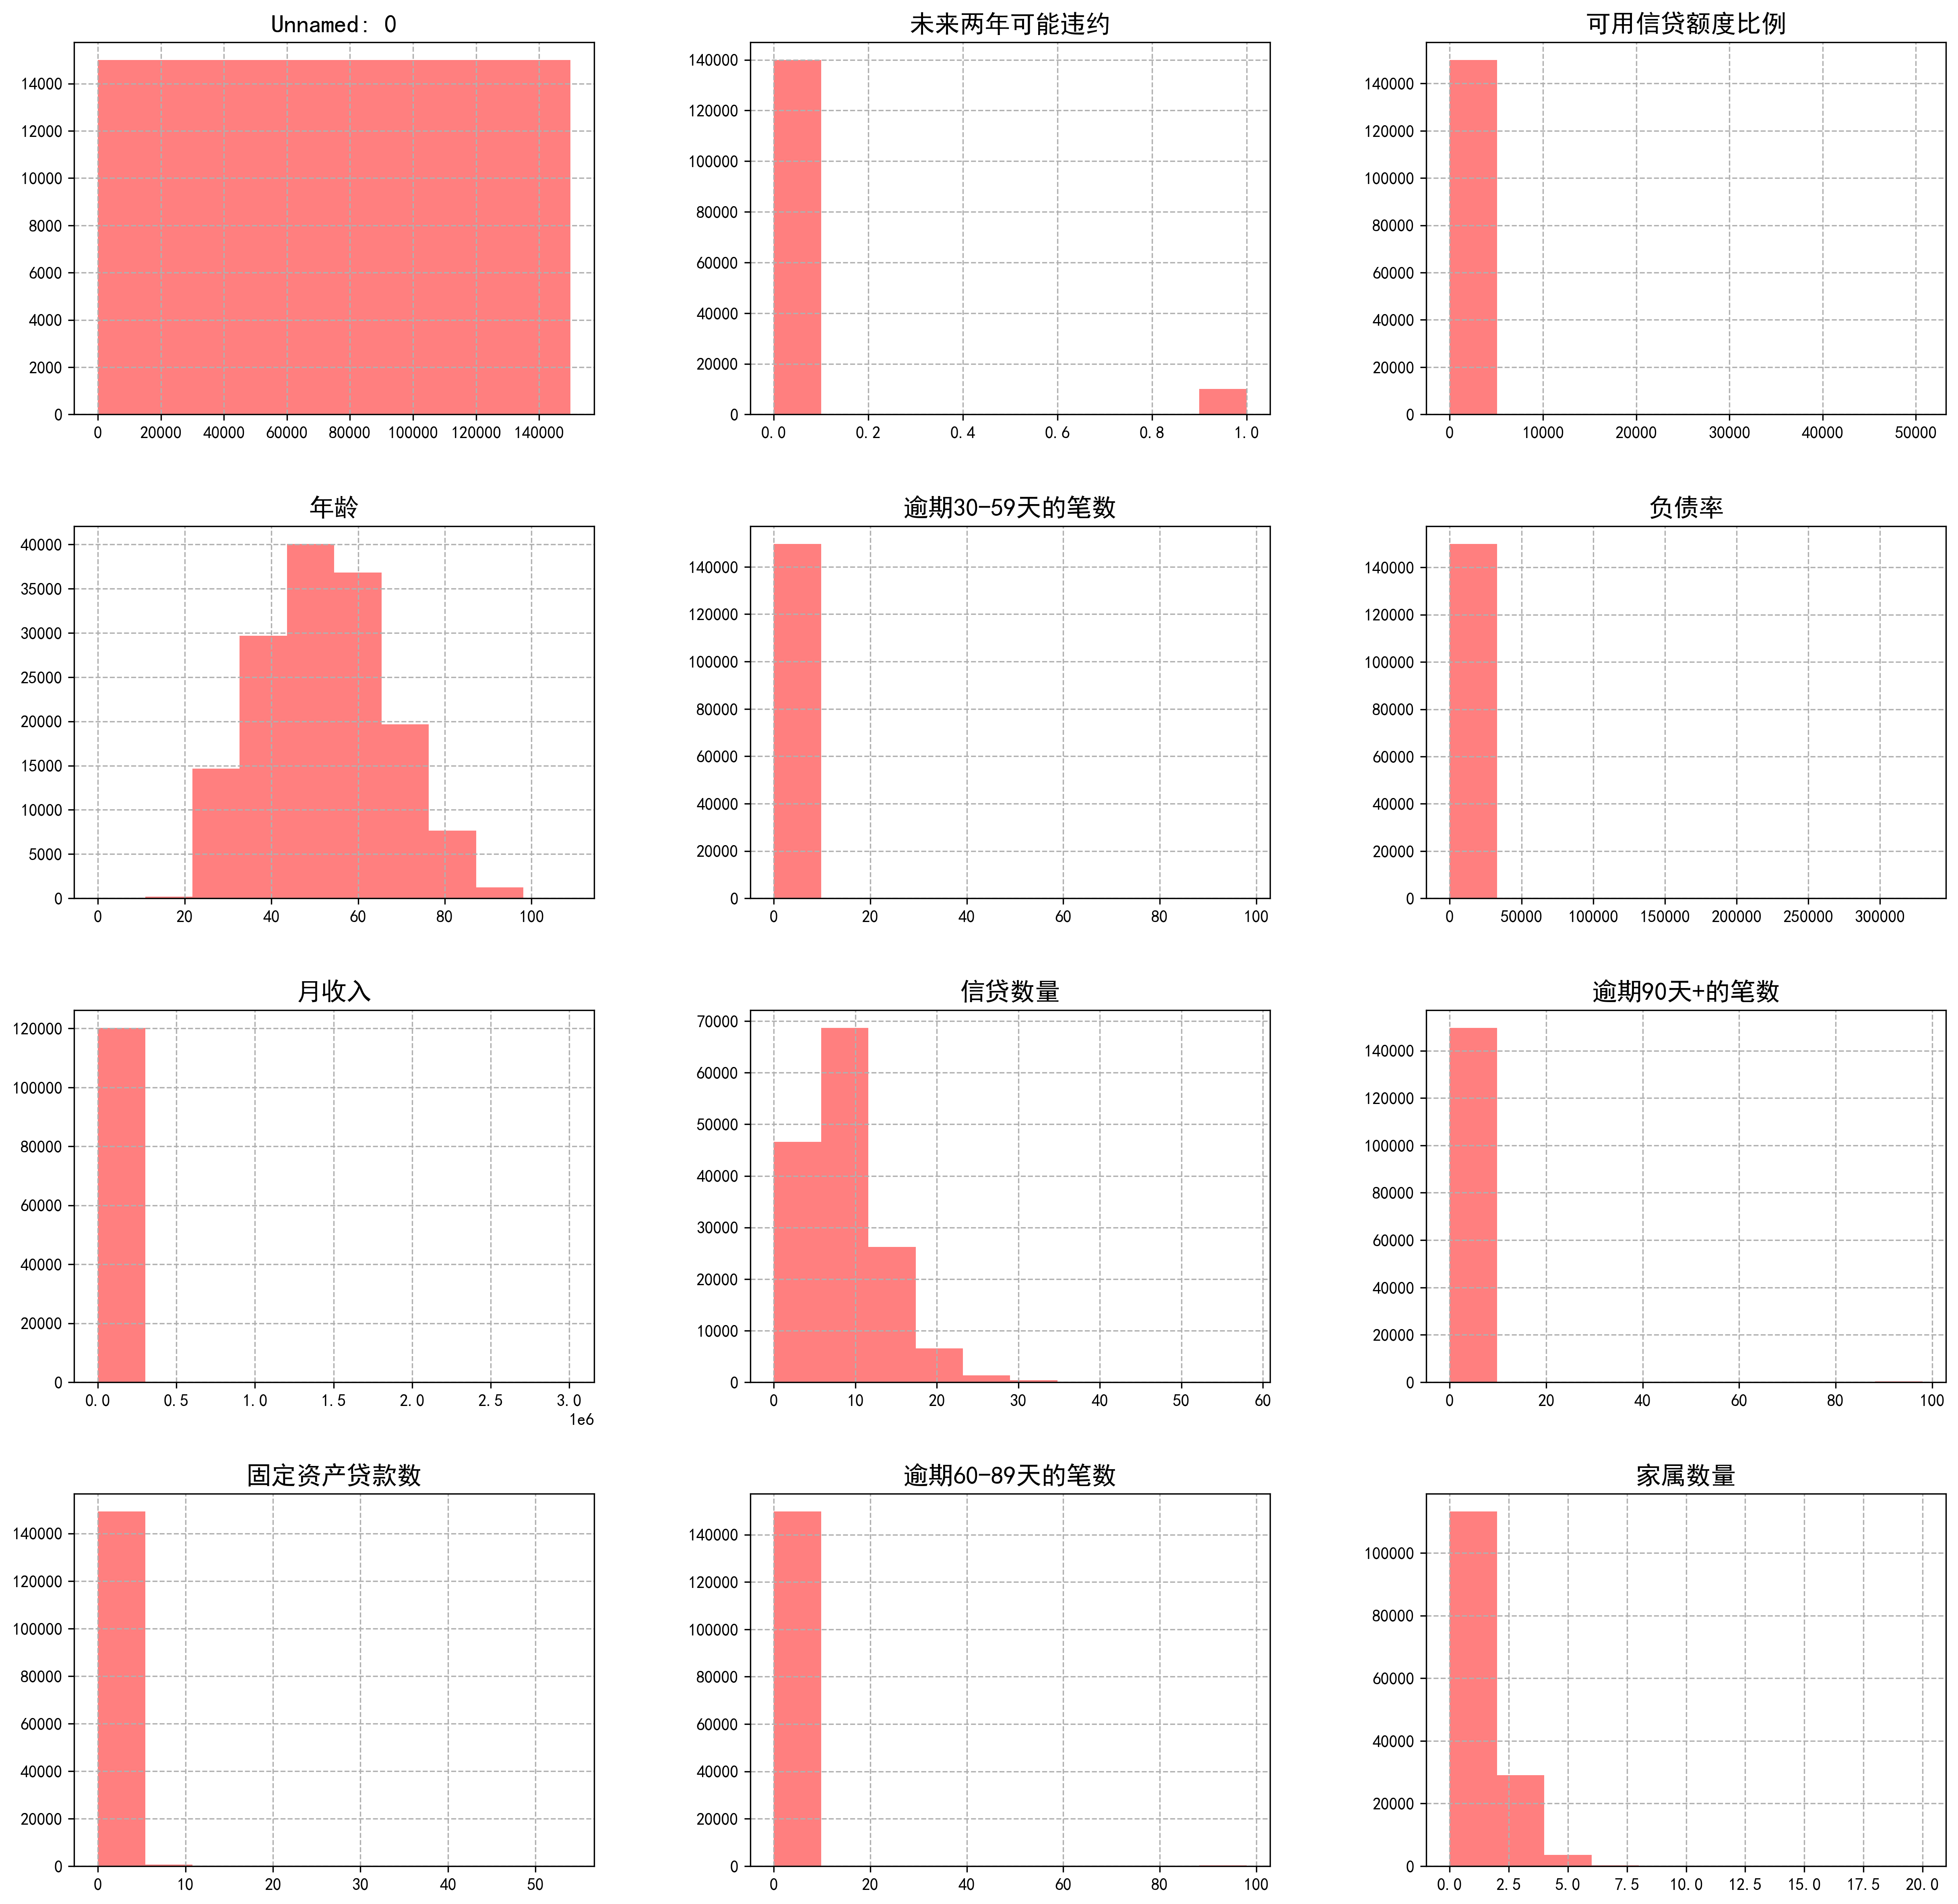

In [11]:
#绘制标签值和特征值的直方图
plt.figure(figsize=(20,20),dpi=300)
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for n,i in enumerate(df0.columns):
    plt.subplot(4,3,n+1)
    plt.title(i,fontsize=15)
    plt.grid(linestyle='--')
    df0[i].hist(color='red',alpha=0.5)
    
#结果显示，大多数字段明显偏态，后续建模需要纠偏处理

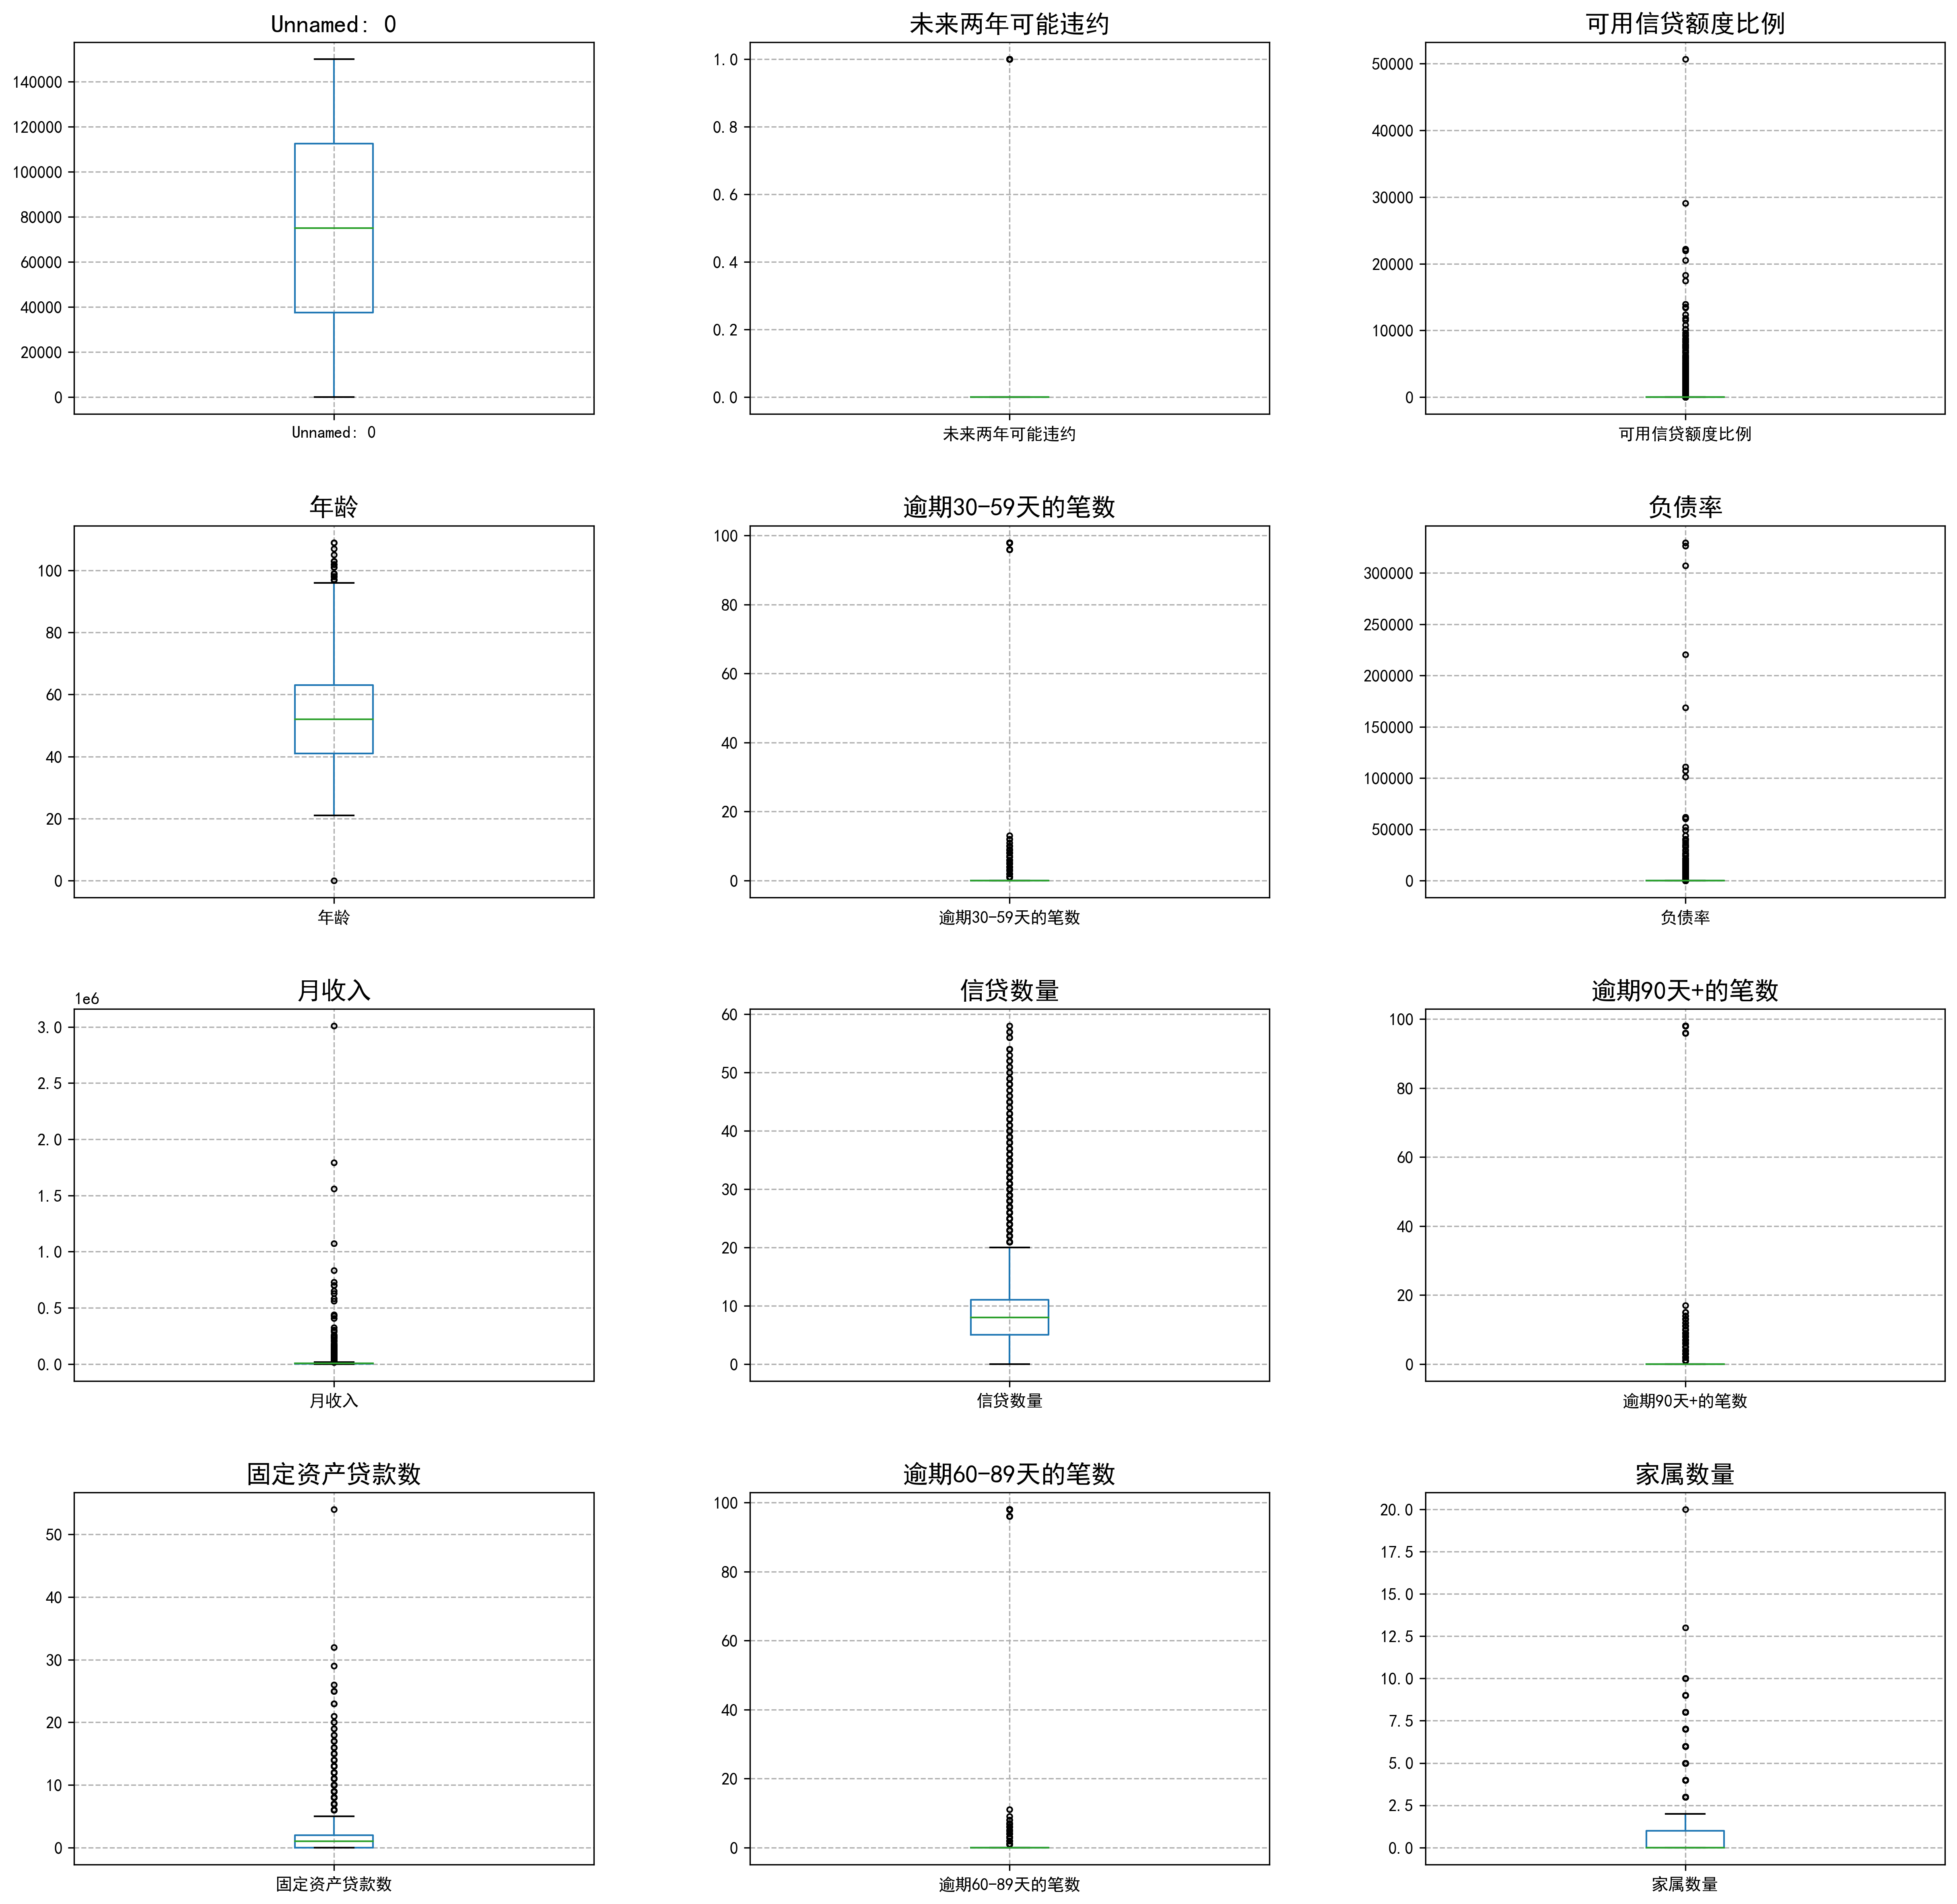

In [12]:
#通过箱型图观察各字段异常情况
plt.figure(figsize=(20,20),dpi=300)
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for n,i in enumerate(df0.columns):
    plt.subplot(4,3,n+1)
    plt.title(i,fontsize=15)
    plt.grid(linestyle='--')
    df0[[i]].boxplot(sym='.')
    
#结果显示负债率异常值（错误）较多；可用信贷额度比例 异常值（错误）较多，理论应小于或等于1
#  '逾期30-59天的笔数', '负债率', '月收入','逾期90天+的笔数', '固定资产贷款数', '逾期60-89天的笔数'异常值非常多，难以观察数据分布。

<AxesSubplot:>

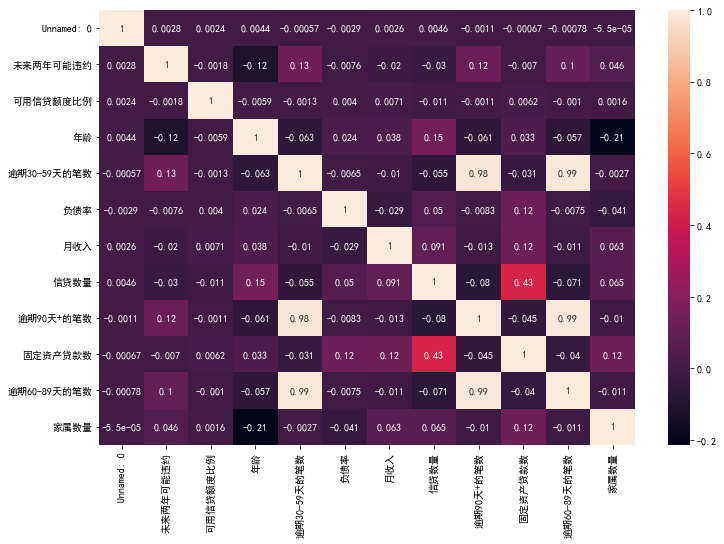

In [13]:
#数据相关性分析
corr = df0.corr()
corr
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)  # 三个参数，分别表示在一个大的画图空间fig中，前两个参数分别代表子图的行数和列数，最后一个参数1代表第1个子图
sns.heatmap(corr,annot = True,ax = ax1)  # annot为annotate的缩写，默认为False，当annot为True时，在heatmap中每个方格写入数据

# 4、数据预处理

In [14]:
#构建异常值及明显错误处理函数
def error_processing(df):
    '''
    异常值处理，可根据建模效果，反复调节处理方案，建议谨慎删除数据。
    df：数据源
    '''
    def show_error(df,col,whis=1.5,show=False):
        '''
        显示上下限异常值数量，可选显示示例异常数据
        df：数据源
        col：字段名
        whis：默认1.5，对应1.5倍iqr
        show：是否显示示例异常数据
        '''
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        upper_bound = df[col].quantile(0.75) + whis * iqr # 上界
        lower_bound = df[col].quantile(0.25) - whis * iqr # 下界
        # print(iqr,upper_bound,lower_bound)
        print('【',col,'】上界异常值总数：',df[col][df[col] > upper_bound].count())
        if show:
            print('异常值示例：\n',df[df[col] > upper_bound].head(5).T)
        print('【',col,'】下界异常值总数：',df[col][df[col] < lower_bound].count())
        if show:
            print('异常值示例：\n',df[df[col] < lower_bound].head(5).T)
        print('- - - - - - ')

    def drop_error(df,col):
        '''
        删除上下限异常值数量
        df：数据源
        col：字段名
        '''
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        upper_bound = df[col].quantile(0.75) + 1.5*iqr # 上界
        lower_bound = df[col].quantile(0.25) - 1.5*iqr # 下界
        data_del = df[col][(df[col] > upper_bound) | (df[col] < lower_bound)].count()
        data = df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]
        # print('总剔除数据量：',data_del)
        return data
    
    # 计数器
    n = len(df)
    
    # 可用信贷额度
    # 从分布直方图可知，比例大于1的应该为错误值。
    # 错误值共3321，若剔除可能影响建模效果。剔除>=20000的数据
    show_error(df,'可用信贷额度比例')
    df = df[df.可用信贷额度比例<=20000]

    # 年龄
    # 异常值数量不多，剔除年龄大于100小于18的异常数据
    show_error(df,'年龄')
    df = df[(df['年龄']>18) & (df['年龄']<100)]

    # 逾期30-59天的笔数
    # 根据箱型图去除>80的异常数据
    show_error(df,'逾期30-59天的笔数')
    df = df[df['逾期30-59天的笔数']<80]

    # 逾期90天+的笔数
    # 根据箱型图去除>80的异常数据
    show_error(df,'逾期90天+的笔数')
    df = df[df['逾期90天+的笔数']<80]

    # 逾期60-89天的笔数
    # 根据箱型图去除>80的异常数据
    show_error(df,'逾期60-89天的笔数')
    df = df[df['逾期60-89天的笔数']<80]

    # 负债率
    # 根据箱型图去除>100000的异常数据
    show_error(df,'负债率')
    df = df[df['负债率']<100000]

    # 月收入
    # 根据箱型图去除>500000的异常数据
    show_error(df,'月收入')
    df = df[(df['月收入']<500000) | df.月收入.isna()]

    # 固定资产贷款数
    # 根据箱型图去除>20的异常数据
    show_error(df,'固定资产贷款数')
    df = df[df['固定资产贷款数']<20]

    # 家属数量
    # 根据箱型图去除>10的异常数据
    show_error(df,'家属数量')
    df = df[(df['家属数量']<12)|df.家属数量.isna()]

    # 信贷数量 - 保留异常值
    
    print('共删除数据 ',n - len(df),' 条。')

In [15]:
#构建去除共线性函数
#考虑保留'逾期90天+的笔数'，求出'逾期60-89天的笔数'/'逾期30-59天的笔数'的比值
def collineation_processing(df,col,col1,col2,name):
    '''
    去除共线性，保留一个字段，其他字段求比值
    df：数据源
    col：保留字段
    col1，col2：求比值字段
    name：新比值字段名称
    '''
    def trans2percent(row):
        if row[col2] == 0:
            return 0
        else:
            return row[col1] / row[col2]
    df[name] = df.apply(trans2percent,axis=1)
#     df[[name,col]].corr()
    
# collineation_processing(df,'逾期90天+的笔数'，'逾期60-89天的笔数'，'逾期30-59天的笔数'，'逾期60-89天/30-59天')


In [16]:
#构建缺失值处理函数
def missing_values_processing(df,func1=1,func2=1):
    '''
    缺失值处理
    df：数据源
    func1：默认为1，众数填充家属；0，去除带空值数据行。
    func2：默认为1，众数填充月收入；0，平均数填充月收入。
    '''
    # 家属数量 - 剔除或众数填充
    if func1 == 1:
        df.loc[df.家属数量.isna(),'家属数量'] = df.家属数量.mode()[0]
    elif func1 == 0:
        df = df.dropna(subset=['家属数量'])
    else:
        print('parameter wrong!')
    
    # 月收入 - 剔除或均值填充
    if func1 == 1:
        df.loc[df.月收入.isna(),'月收入'] = df.月收入.mode()[0]
    elif func1 == 0:    
        df.loc[df.月收入.isna(),'月收入'] = df.月收入.mean()[0]
    else:
        print('parameter wrong!')

重新抽样

In [17]:
#未来两年可能违约的标签类别分布不均，需对样本进行重新取样
def resample(df):
    '''
    使样本'未来两年可能违约'标签的0，1项可以各占一半，以提高预测效果。sample()可以考虑添加random_state以便生成相同样本集
    df：数据源
    '''
    num = df['未来两年可能违约'].value_counts()[1]
    df_t = df[df.未来两年可能违约==1]
    df_f = df[df.未来两年可能违约==0].sample(frac=1)[0:num]
    df_balanced = pd.concat([df_t,df_f]).sample(frac=1).reset_index(drop=True)
#     print(df_balanced.未来两年可能违约.value_counts())
    return df_balanced

# 5、模型训练

In [18]:
# 设 【 df1 】 为违约概率模型建模所用数据集
df1 = df0.copy()

# 异常处理
error_processing(df1)
# 去除共线性
collineation_processing(df1,'逾期90天+的笔数', '逾期60-89天的笔数', '逾期30-59天的笔数','逾期60-89天/30-59天')
# 缺失值处理
missing_values_processing(df1,func1=1,func2=1)
# 数据重采样
df_balanced = resample(df1)

# 最后将数据集划分成训练集和验证集，两者划分比例都为8：2
# 可考虑删去的列：'逾期30-59天的笔数','逾期60-89天的笔数','逾期90天+的笔数','逾期60-89天/30-59天','未来两年可能违约'
X = df_balanced.drop(['未来两年可能违约','逾期60-89天/30-59天'],axis=1) 
y = df_balanced['未来两年可能违约']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)    # random_state=42

# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=3,shuffle=True)

【 可用信贷额度比例 】上界异常值总数： 763
【 可用信贷额度比例 】下界异常值总数： 0
- - - - - - 
【 年龄 】上界异常值总数： 45
【 年龄 】下界异常值总数： 1
- - - - - - 
【 逾期30-59天的笔数 】上界异常值总数： 23980
【 逾期30-59天的笔数 】下界异常值总数： 0
- - - - - - 
【 逾期90天+的笔数 】上界异常值总数： 8068
【 逾期90天+的笔数 】下界异常值总数： 0
- - - - - - 
【 逾期60-89天的笔数 】上界异常值总数： 7335
【 逾期60-89天的笔数 】下界异常值总数： 0
- - - - - - 
【 负债率 】上界异常值总数： 31271
【 负债率 】下界异常值总数： 0
- - - - - - 
【 月收入 】上界异常值总数： 4876
【 月收入 】下界异常值总数： 0
- - - - - - 
【 固定资产贷款数 】上界异常值总数： 793
【 固定资产贷款数 】下界异常值总数： 0
- - - - - - 
【 家属数量 】上界异常值总数： 13326
【 家属数量 】下界异常值总数： 0
- - - - - - 
共删除数据  322  条。


In [19]:
#分类模型性能查看函数
def perfomance_clf(model,X,y,name=None):
    y_predict = model.predict(X)
    if name:
        print(name,':')
    print(f'accuracy score is: {accuracy_score(y,y_predict)}')
    print(f'precision score is: {precision_score(y,y_predict)}')
    print(f'recall score is: {recall_score(y,y_predict)}')
    print(f'auc: {roc_auc_score(y,y_predict)}')
    print('- - - - - - ')

逻辑回归模型

In [20]:
# 参数设定
log_params = {"penalty":['l1','l2'],
                 'C':[0.001*10**i for i in range(0,7)]}
# 参数搜索
log_gridsearch = GridSearchCV(LogisticRegression(solver='liblinear'),log_params,cv=cv,
                               n_jobs=-1,scoring='roc_auc',verbose=2,refit=True)
# 工作流管道
pipe_log = Pipeline([
        ('sc',StandardScaler()),    # 标准化Z-score
        ('pow_trans',PowerTransformer()),    # 纠偏
        ('log_grid',log_gridsearch)
        ])
# 搜索参数并训练模型
pipe_log.fit(xtrain,ytrain)
# 最佳参数组合
print(pipe_log.named_steps['log_grid'].best_params_)
# 训练集性能指标
perfomance_clf(pipe_log,xtrain,ytrain,name='train')
# 测试集性能指标
perfomance_clf(pipe_log,xtest,ytest,name='test')

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'C': 0.1, 'penalty': 'l1'}
train :
accuracy score is: 0.770961910105355
precision score is: 0.7953902143145977
recall score is: 0.7324066029539531
auc: 0.7711381712164556
- - - - - - 
test :
accuracy score is: 0.7703814510097232
precision score is: 0.7826321467098166
recall score is: 0.7369222955815135
auc: 0.7697833808955559
- - - - - - 


In [21]:
#交叉验证查看平均分数
cross_val_score(pipe_log,xtrain,ytrain,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits


0.855736459433096

随机森林分类模型

In [22]:
rf_clf = RandomForestClassifier(criterion='gini',
                               n_jobs=-1,
                               n_estimators=1000)    # random_state
# 参数设定
rf_grid_params = {'max_features':['auto'],    # ['auto',0.5,0.6,0.9] 未知最优参数时可以自己设定组合
                    'max_depth':[6,9]}    # [3,6,9]
# 参数搜索
rf_gridsearch = GridSearchCV(rf_clf,rf_grid_params,cv=cv,
                               n_jobs=-1,scoring='roc_auc',verbose=10,refit=True)
# 工作流管道
pipe_rf = Pipeline([
        ('sc',StandardScaler()),
        ('pow_trans',PowerTransformer()),
        ('rf_grid',rf_gridsearch)
        ])
# 搜索参数并训练模型
pipe_rf.fit(xtrain,ytrain)
# 最佳参数组合
print(pipe_rf.named_steps['rf_grid'].best_params_)
# 训练集性能指标
perfomance_clf(pipe_rf,xtrain,ytrain,name='train')
# 测试集性能指标
perfomance_clf(pipe_rf,xtest,ytest,name='test')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'max_depth': 9, 'max_features': 'auto'}
train :
accuracy score is: 0.8137896639860358
precision score is: 0.8150633855331841
recall score is: 0.8139506019610276
auc: 0.8137889282350229
- - - - - - 
test :
accuracy score is: 0.7796060832710048
precision score is: 0.7642474427666829
recall score is: 0.7968511934992382
auc: 0.77991433328243
- - - - - - 


In [23]:
#交叉验证查看平均分数
cross_val_score(pipe_rf,xtrain,ytrain,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


0.8609366345493369

XGBoost模型

In [24]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            n_job=-1,
                            booster='gbtree',
                            n_estimators=1000,
                            learning_rate=0.01)
# 参数设定
xgb_params = {'max_depth':[6,9],    # 注意参数设置，数量多了会更加耗时
             'subsample':[0.6,0.9],
             'colsample_bytree':[0.5,0.6],
             'reg_alpha':[0.05,0.1]}
# 参数搜索
xgb_gridsearch = GridSearchCV(xgb_clf,xgb_params,cv=cv,n_jobs=-1,
                                 scoring='roc_auc',verbose=10,refit=True)
# 工作流管道
pipe_xgb = Pipeline([
    ('sc',StandardScaler()),
    ('pow_trans',PowerTransformer()),
    ('xgb_grid',xgb_gridsearch)
])
# 搜索参数并训练模型
pipe_xgb.fit(xtrain,ytrain)
# 最佳参数组合
print(pipe_xgb.named_steps['xgb_grid'].best_params_)
# 训练集性能指标
perfomance_clf(pipe_xgb,xtrain,ytrain,name='train')
# 测试集性能指标
perfomance_clf(pipe_xgb,xtest,ytest,name='test')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[17:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_job" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'colsample_bytree': 0.5, 'max_depth': 6, 'reg_alpha': 0.1, 'subsample': 0.6}
train :
accuracy score is: 0.8245121875194813
precision score is: 0.8309343434343435
recall score is: 0.8168052625046544
auc: 0.8245474208314856
- - - - - - 
test :
accuracy score is: 0.7850909997506856
precision score is: 0.7757847533632287
recall score is: 0.7907567293042154
auc: 0.7851922725855063
- - - - - - 


In [25]:
#交叉验证查看平均分数
cross_val_score(pipe_xgb,xtrain,ytrain,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[18:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_job" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[18:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_job" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting 3 folds for each of 16 candidates, totalli

0.8620799079343064

由结果显示，XGBoost的效果最好

Index(['Unnamed: 0', '可用信贷额度比例', '年龄', '逾期30-59天的笔数', '负债率', '月收入', '信贷数量',
       '逾期90天+的笔数', '固定资产贷款数', '逾期60-89天的笔数', '家属数量'],
      dtype='object')

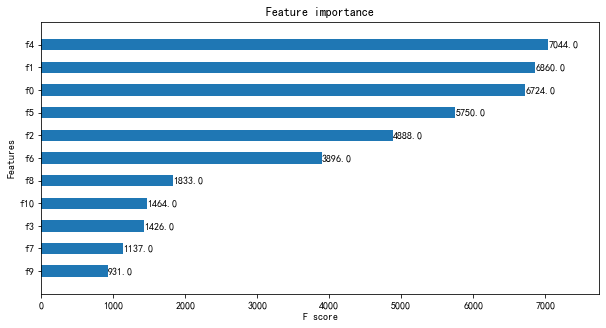

In [26]:
#查看字段对XGBOOST的重要程度
#一般显示 ['可用信贷额度比例', '年龄', '负债率', '月收入', '信贷数量'] 这些字段比较重要
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
xgb.plot_importance(pipe_xgb.named_steps['xgb_grid'].best_estimator_,
                       max_num_features=40,height=0.5,grid=False,ax=ax)
xtrain.columns

# 6、预测并生成结果

In [29]:
# 预测集数据读取与处理
dftest = pd.read_csv('cs-test.csv')
dftest.rename(columns = {'SeriousDlqin2yrs':'未来两年可能违约', 'RevolvingUtilizationOfUnsecuredLines':'可用信贷额度比例', 'age':'年龄',
      'NumberOfTime30-59DaysPastDueNotWorse':'逾期30-59天的笔数', 'DebtRatio':'负债率', 'MonthlyIncome':'月收入',
       'NumberOfOpenCreditLinesAndLoans':'信贷数量', 'NumberOfTimes90DaysLate':'逾期90天+的笔数',
      'NumberRealEstateLoansOrLines':'固定资产贷款数', 'NumberOfTime60-89DaysPastDueNotWorse':'逾期60-89天的笔数',
      'NumberOfDependents':'家属数量'},inplace=True)
dftest.loc[dftest.家属数量.isna(),'家属数量'] = df1.家属数量.mode()[0]
dftest.loc[dftest.月收入.isna(),'月收入'] = df1.月收入.mode()[0]


In [31]:
# 以xgboost模型预测，生成csv结果文件
result = pipe_xgb.predict_proba(dftest.drop('未来两年可能违约',axis=1))
result_ = [[n+1,i] for n,i in enumerate(result[:,1])]
df_result = pd.DataFrame(result_,columns=['Id','Probability'])
df_result.to_csv('sampleEntry_7_2.csv',index=False)
df_result

,Id,Probability
0,1,0.456925
1,2,0.435004
2,3,0.152336
3,4,0.549952
4,5,0.653203
...,...,...
101498,101499,0.355076
101499,101500,0.911948
101500,101501,0.044546
101501,101502,0.588830


In [ ]:
# 模型保存方法
import pickle
with open('pipe_log.pickle','wb') as f:
    pickle.dump(pipe_log,f)
with open('pipe_log.pickle','rb') as f:
    clf = pickle.load(f)

根据违约概率的值，将客户划分等级，违约概率在0-0.1之间的分为A级，违约概率在0.1-0.2之间的分为B级，违约概率在0.2-0.3之间的分为C级，违约概率在0.3-0.4之间的分为D级，违约概率在0.4-0.5之间的分为E级，违约概率在0.5-0.6之间的分为F级，违约概率在0.6以上的分为G级。银行在对客户进行信用评估的时候可参考该客户所处的信用等级来决定是否给该客户发放贷款。